In [1]:
import os
import jax
os.environ["KERAS_BACKEND"] = "jax"
import keras
import matplotlib.pyplot as plt
import numpy as np

In [3]:
x = keras.ops.ones(shape=(2, 1))
x



Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


Metal device set to: Apple M3 Pro


W0000 00:00:1732561111.207968 35839590 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1732561111.219700 35839590 service.cc:145] XLA service 0x60000378a000 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732561111.219716 35839590 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1732561111.222024 35839590 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1732561111.222031 35839590 mps_client.cc:384] XLA backend will use up to 28989243392 bytes on device 0 for SimpleAllocator.


Array([[1.],
       [1.]], dtype=float32)

In [4]:
x = keras.ops.zeros(shape=(2,1))

In [10]:
rand_x = keras.random.uniform(shape=(3,1))

rand_x

Array([[0.30910337],
       [0.25909734],
       [0.5616666 ]], dtype=float32)

In [14]:
v = keras.Variable(keras.random.normal(shape=(3,1)))
v.value

Array([[-0.32251447],
       [ 1.0465071 ],
       [-0.8690599 ]], dtype=float32)

In [17]:
v.assign(v + 1.0)

Array([[0.6774855 ],
       [2.0465071 ],
       [0.13094008]], dtype=float32)

In [18]:
keras.ops.square(v)

Array([[0.45898664],
       [4.1881914 ],
       [0.0171453 ]], dtype=float32)

In [36]:

input_const = keras.ops.convert_to_tensor([3.])
input_const.shape

def sq_tens(x):
    return keras.ops.sum(keras.ops.square(x))
g_func = jax.value_and_grad(sq_tens)
g_func(input_const)

(Array(9., dtype=float32), Array([6.], dtype=float32))

In [38]:
a = 2.0
b = 3.0
jax.grad(jax.lax.mul)(b, a)

Array(2., dtype=float32, weak_type=True)

In [41]:
def position(time):
    return 4.9 * (time ** 2.0)
d1_func = jax.grad(position)
d1 = d1_func(2.0)
d2 = jax.grad(d1_func)(d1)
d2

Array(9.8, dtype=float32)

In [2]:
num_samples_per_class = 1000
cvr_mat = [[1., 0.5],[0.5, 1.]]
negative_samples = np.random.multivariate_normal(mean=[0,3], cov=cvr_mat, size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(mean=[3,0], cov=cvr_mat, size=num_samples_per_class)


In [8]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack((np.zeros((negative_samples.shape[0], 1)), np.ones((positive_samples.shape[0], 1))))

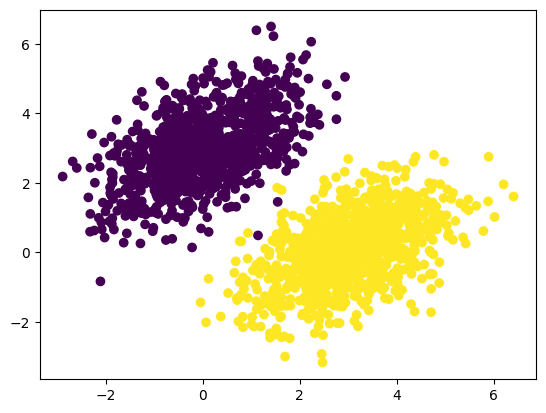

In [9]:
plt.scatter(inputs[:,0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [13]:
input_dim = 2
output_dim = 1
W = keras.Variable(keras.random.uniform(shape=(input_dim, output_dim)))
b = keras.Variable(keras.ops.zeros((output_dim, )))

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1732571352.279099 35980374 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1732571352.292471 35980374 service.cc:145] XLA service 0x600003f25400 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732571352.292488 35980374 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1732571352.294729 35980374 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1732571352.294738 35980374 mps_client.cc:384] XLA backend will use up to 28989243392 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M3 Pro


In [30]:
def model(x, mW, mB):
    return keras.ops.matmul(x, mW) + mB

def loss(y_true, y_pred):
    per_sample_loss = keras.ops.square(y_true - y_pred)
    return keras.ops.mean(per_sample_loss)

def forward_train(x, y_true, mW, mB):
    y_pred = model(x, mW, mB)
    return loss(y_true, y_pred), y_pred
                    

learning_rate = 0.1
def training_step(x_in, y_true, inW, inB):
    # only care about gradients for W and B
    grad_train_model = jax.value_and_grad(forward_train, argnums=[2, 3], has_aux=True)
    (l_val, pred_val), grads = grad_train_model(x_in, y_true, inW, inB)
    w_grads = grads[0]
    b_grads = grads[1]
    newW = inW - (w_grads * learning_rate)
    newB = inB - (b_grads * learning_rate)
    return l_val, newW, newB
    
    
    
    

In [20]:
try_y = model(inputs)
loss(targets, try_y)


Array(4.8825245, dtype=float32)

In [33]:
out_loss, outW, outB = training_step(inputs, targets, W, b)
print(out_loss)
print(outW)
print(outB)

4.8825245
[[ 0.14710087]
 [-0.14929527]]
[-0.35213992]


In [34]:
curW = W
curB = b
for step in range(40):
    new_loss, latestW, latestB = training_step(inputs, targets, curW, curB)
    curW = latestW
    curB = latestB
    print("LOSS: ", new_loss)

LOSS:  4.8825245
LOSS:  0.7578826
LOSS:  0.22896037
LOSS:  0.1519796
LOSS:  0.13341615
LOSS:  0.12305771
LOSS:  0.11444013
LOSS:  0.1066793
LOSS:  0.09960729
LOSS:  0.093152285
LOSS:  0.0872591
LOSS:  0.08187865
LOSS:  0.076966316
LOSS:  0.07248136
LOSS:  0.068386585
LOSS:  0.06464808
LOSS:  0.061234806
LOSS:  0.05811851
LOSS:  0.05527332
LOSS:  0.052675676
LOSS:  0.05030402
LOSS:  0.04813871
LOSS:  0.046161775
LOSS:  0.04435684
LOSS:  0.042708933
LOSS:  0.0412044
LOSS:  0.039830763
LOSS:  0.03857663
LOSS:  0.037431613
LOSS:  0.036386207
LOSS:  0.035431758
LOSS:  0.03456034
LOSS:  0.033764742
LOSS:  0.033038363
LOSS:  0.032375176
LOSS:  0.031769685
LOSS:  0.031216878
LOSS:  0.030712167
LOSS:  0.030251363
LOSS:  0.029830648


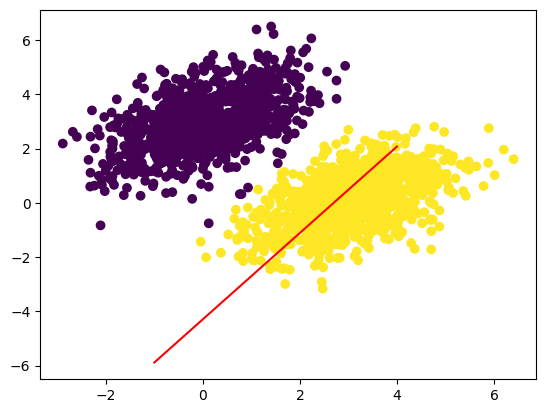

In [38]:
predictions = model(inputs, curW, curB)
plot_x = np.linspace(-1, 4, 100)
plot_y = ((-1 * curW[0]) / curW[1]) * plot_x + (0.5 - b) / curW[1]
plt.plot(plot_x, plot_y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)